In [1]:
import torch
from Define_Model.ResNet import LocalResNet
from Define_Model.Loss.SoftmaxLoss import AdditiveMarginLinear
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import Process_Data.constants as c
from matplotlib.backends.backend_pdf import PdfPages

from python_speech_features import mel2hz
import matplotlib
# del matplotlib.font_manager.weight_dict['roman']
# mf = matplotlib.font_manager.FontManager()
# mf.set_default_weight(weight='medium') #[source]
%matplotlib inline

In [2]:
m = np.linspace(0, 2840.0230467083188, 40)
x = mel2hz(m)

/home/yangwenhao/local/project/SpeakerVerification-pytorch/Define_Model/Loss/SoftmaxLoss.py:154: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.W, gain=1)


mel: w:  Parameter containing:
tensor(2.4906, requires_grad=True)  b:  Parameter containing:
tensor(-1.9866, requires_grad=True)


/home/yangwenhao/local/project/SpeakerVerification-pytorch/Define_Model/Loss/SoftmaxLoss.py:154: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.W, gain=1)


clean: w:  Parameter containing:
tensor(2.1722, requires_grad=True)  b:  Parameter containing:
tensor(-2.2251, requires_grad=True)
aug: w:  Parameter containing:
tensor(2.1427, requires_grad=True)  b:  Parameter containing:
tensor(-2.0633, requires_grad=True)


/home/yangwenhao/local/project/SpeakerVerification-pytorch/Define_Model/Loss/SoftmaxLoss.py:154: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.W, gain=1)
/home/yangwenhao/local/project/SpeakerVerification-pytorch/Define_Model/Loss/SoftmaxLoss.py:154: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.W, gain=1)


vox2: w:  Parameter containing:
tensor(2.1375, requires_grad=True)  b:  Parameter containing:
tensor(-1.9554, requires_grad=True)


/tmp/ipykernel_2821457/4101937729.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  pdf.savefig(layout='tight')


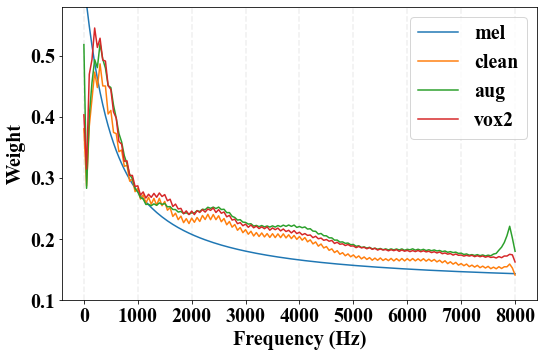

In [19]:
x = np.arange(161) * 8000 / (161 - 1)

pdf = PdfPages('grads.pdf')

plt.figure(figsize=(8.5, 5.4))
plt.rc('font', family='Times New Roman', weight='semibold')

# fonti = {'weight':'normal'}

# for weight in ['rand', "mel", "clean", "aug", "vox2", ]:
for weight in ["mel", "clean", "aug", "vox2", ]:

    # for weight in ["clean", "aug", "mel"]:

    c_model = LocalResNet(embedding_size=256, num_classes=1211, block_type='cbam',
                     input_dim=161, input_len=300, gain_layer=False, init_weight=weight,
                     relu_type='relu', resnet_size=8, channels=[32, 64, 128], dropout_p=0.20, encoder_type='None',
                     input_norm='Mean', alpha=0, stride=2, transform=False, time_dim=1, fast='None',
                     avg_size=4, kernal_size=5, padding=2, filter=None, mask='attention', mask_len=25,)

    c_model.classifier = AdditiveMarginLinear(feat_dim=256, num_classes=1211)

    if weight == 'rand':
        model_ckp = torch.load('/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/checkpoint/LoResNet8/vox1/klsp_egs_attention/arcsoft_sgd_rop/Mean_cbam_None_dp20_alpha0_em256_%s_chn32_wd5e4_var/checkpoint_50.pth'%weight)
    else:
        model_ckp = torch.load('/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/checkpoint/LoResNet8/vox1/klsp_egs_attention/arcsoft/Mean_cbam_None_dp20_alpha0_em256_%s_chn32_wd5e4_var/checkpoint_50.pth'%weight)

    model_static = model_ckp['state_dict']
    c_model.load_state_dict(model_static)

    w = c_model.mask_layer.w
    b = c_model.mask_layer.b
    
#     w = 2
#     b = -1
    print("%s: w: "%weight, w, " b: ", b)
    activation = c_model.mask_layer.activation

    ynew = c_model.mask_layer.drop_p# c.VOX1_CLEAN
    drop_weight = torch.tensor(ynew).reshape(1, 1, 1, -1).float()
    drop_weight = activation(w * drop_weight + b)

#     plt.plot(x[6:], drop_weight.squeeze().detach().numpy()[6:])
    plt.plot(x, drop_weight.squeeze().detach().numpy(), linewidth=1.5)

# plt.plot([300,300, 300], [0, 0.2, 0.65], color='grey', linestyle='--', linewidth=1)
plt.ylim(0.1, 0.58)
plt.legend(["mel", "clean", "aug", "vox2", ], loc='best', fontsize=20)
# plt.legend(['rand', "mel", "clean", "aug", "vox2", ], loc='best', fontsize=20)

plt.xlabel('Frequency (Hz)', fontsize=20, fontweight=600)
plt.xticks(fontsize=20)
plt.ylabel('Weight', fontsize=20, fontweight=600)
plt.yticks(fontsize=20)
plt.grid(linestyle='--', axis='x', alpha=0.2, linewidth=1.5)

pdf.savefig(layout='tight')
pdf.close()

tensor(0.1944)
tensor(0.2316)
tensor(0.1489)


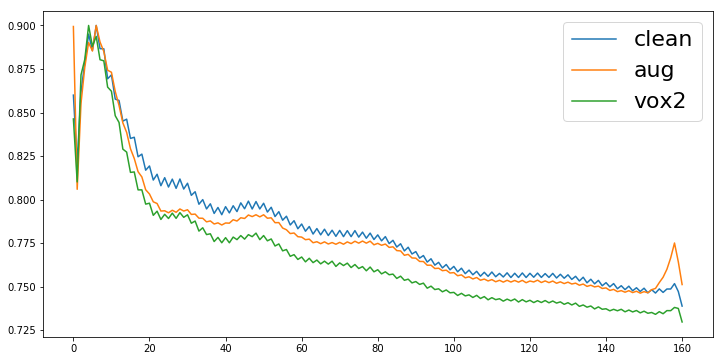

In [9]:
softmax = torch.nn.Softmax(dim=0)
plt.figure(figsize=(12, 6))

for x in [c.VOX1_CLEAN, c.VOX1_AUG, c.VOX2_CLEAN]:
    np_x = torch.FloatTensor(np.array(x))
    np_x /= np_x.max()
#     np_x = 10*softmax(10*np_x)
    print(np_x.min())
    plt.plot(np_x*0.2+0.8-0.1)

plt.legend(["clean", "aug", "vox2"], fontsize=22)
# plt.ylim(0,1)
# print(drop_weight)
# print(ynew)